In [ ]:
#Packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from google.colab import files
import matplotlib.pyplot as plt
import sklearn.linear_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from ipywidgets import interact, FloatSlider
from sklearn.tree import DecisionTreeRegressor, plot_tree
import plotly.express as px
!pip install stargazer
from stargazer.stargazer import Stargazer
import statsmodels.api as sm

In [ ]:
#Datasets
housing=pd.read_csv('Housing1.csv') #Housing Price Data
macro1=pd.read_csv('MacroData1Final.csv') #Various macroeconomic and social indicators pt. 1
macro2=pd.read_csv('MacroData2Final.csv') #Various macroeconomic and social indicators pt. 2

In [ ]:
#Data Cleaning - Getting rid of whitespace and converting to lowercase
housing['County'] = housing['County'].astype(str).str.strip().str.lower()
housing['State'] = housing['State'].astype(str).str.strip().str.lower()
macro1['County'] = macro1['County'].astype(str).str.strip().str.lower()
macro1['State'] = macro1['State'].astype(str).str.strip().str.lower()
macro2['County'] = macro2['County'].astype(str).str.strip().str.lower()
macro2['State'] = macro2['State'].astype(str).str.strip().str.lower()


In [ ]:
#Additional Data Cleaning
housing['Average Price'] = housing['Average Price'].astype(float) #Converting scientic notation to standard notation
housing['Average Price'] = housing['Average Price'].round(2) #Rounding to two decimal points
housing['County'] = housing['County'].str.replace(" county", "", regex=False).str.strip()



#Converting state names to abbreviations
housing['State'] = housing['State'].map({ 'al': 'alabama', 'ak': 'alaska', 'az': 'arizona', 'ar': 'arkansas',
    'ca': 'california', 'co': 'colorado', 'ct': 'connecticut', 'de': 'delaware',
    'fl': 'florida', 'ga': 'georgia', 'hi': 'hawaii', 'id': 'idaho',
    'il': 'illinois', 'in': 'indiana', 'ia': 'iowa', 'ks': 'kansas',
    'ky': 'kentucky', 'la': 'louisiana', 'me': 'maine', 'md': 'maryland',
    'ma': 'massachusetts', 'mi': 'michigan', 'mn': 'minnesota', 'ms': 'mississippi',
    'mo': 'missouri', 'mt': 'montana', 'ne': 'nebraska', 'nv': 'nevada',
    'nh': 'new hampshire', 'nj': 'new jersey', 'nm': 'new mexico', 'ny': 'new york',
    'nc': 'north carolina', 'nd': 'north dakota', 'oh': 'ohio', 'ok': 'oklahoma',
    'or': 'oregon', 'pa': 'pennsylvania', 'ri': 'rhode island', 'sc': 'south carolina',
    'sd': 'south dakota', 'tn': 'tennessee', 'tx': 'texas', 'ut': 'utah',
    'vt': 'vermont', 'va': 'virginia', 'wa': 'washington', 'wv': 'west virginia',
    'wi': 'wisconsin', 'wy': 'wyoming'})

#Getting rid of any rows where county/state is NA
housing = housing.dropna(subset=['County', 'State'])
macro1 = macro1.dropna(subset=['County', 'State'])
macro2 = macro2.dropna(subset=['County', 'State'])



In [ ]:

def clean_county_name(name):
    name = name.lower()
    for suffix in [' county', ' parish', ' borough', ' census area']:
        name = name.replace(suffix, '')
    return name.strip()


for df in [macro1, macro2, housing]:
    df['County'] = df['County'].astype(str).apply(clean_county_name)

macro_merged = pd.merge(macro1, macro2, on=['County', 'State'], how='inner')
final_merged = pd.merge(housing, macro_merged, on=['County', 'State'], how='inner')
final_merged = final_merged.rename(columns={'Population_x': 'Population'})

#Creating if statement that fills NAs in columns with int or float data with that column's median value
for c in final_merged.columns:

    if final_merged[c].dtype not in ['float64', 'int64']:
        continue

    median_value = final_merged[c].median()
    final_merged[c] = final_merged[c].fillna(median_value)

#Creating csv for final merged dataset
final_merged.to_csv("Final Merged Data.csv", index=False)


In [ ]:
#Creating Price Groups
avg_price_county = housing.groupby('County')['Average Price'].mean().reset_index()

#Creating bins for housing price ranges to graph them
bins = [0, 200000, 400000, 600000, 800000, 1000000]
labels = ['0-200K', '200K-400K', '400K-600K', '600K-800K', '800K-1M']
avg_price_county['price_range'] = pd.cut(avg_price_county['Average Price'], bins=bins, labels=labels, include_lowest=True)

price_ranges = avg_price_county['price_range'].value_counts().sort_index()

price_ranges.head()

,count
price_range,
0-200K,768
200K-400K,809
400K-600K,165
600K-800K,39
800K-1M,14


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '0-200K'),
  Text(1, 0, '200K-400K'),
  Text(2, 0, '400K-600K'),
  Text(3, 0, '600K-800K'),
  Text(4, 0, '800K-1M')])

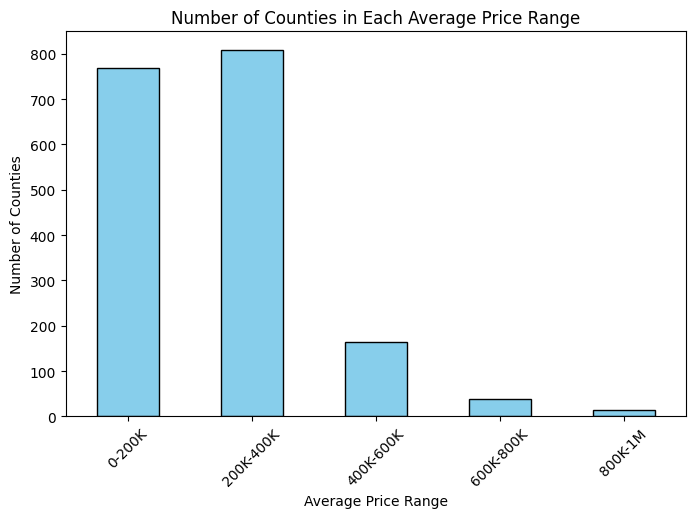

In [ ]:
#Data Visualizations

#Average Sale Price by County
plt.figure(figsize=(8, 5))
price_ranges.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Average Price Range')
plt.ylabel('Number of Counties')
plt.title('Number of Counties in Each Average Price Range')
plt.xticks(rotation=45)

In [ ]:
from stargazer.stargazer import Stargazer
from IPython.core.display import display, HTML
import statsmodels.api as sm

#Health Model
X_health = final_merged[['Life Expectancy', 'Infant Mortality Rate', 'Food Environment Index',
                         '% Vaccinated', 'Dentist Rate', 'HIV Prevalence Rate',
                         '% with Annual Mammogram', 'Drug Overdose Mortality Rate',
                         'Suicide Rate (Age-Adjusted)', '% Fair or Poor Health']]
Y_health = final_merged["Average Price"]
X_health = sm.add_constant(X_health)
model_health = sm.OLS(Y_health, X_health).fit()

#Economic Model
X_econ = final_merged[['Median Household Income', '% Unemployed', 'Spending per Pupil',
                       'School Funding Adequacy', '% Household Income Required for Child Care Expenses',
                       '% Enrolled in Free or Reduced Lunch', '80th Percentile Income',
                       'Income Ratio', '% Uninsured Adults']]
Y_econ = final_merged["Average Price"]
X_econ = sm.add_constant(X_econ)
model_econ = sm.OLS(Y_econ, X_econ).fit()

#Social Model
X_social = final_merged[['High School Graduation Rate', '% Disconnected Youth', 'Segregation Index',
                         'Child Care Centers per 1,000 Children', 'Homicide Rate',
                         '% Voter Turnout', 'Traffic Volume', '% Less than 18 Years of Age',
                         '% Not Proficient in English', 'Juvenile Arrest Rate']]
Y_social = final_merged["Average Price"]
X_social = sm.add_constant(X_social)
model_social = sm.OLS(Y_social, X_social).fit()

#Stargazer Table
stargazer = Stargazer([model_health, model_econ, model_social])
stargazer.title("Regression Results: Health, Economic, and Social Factors")
stargazer.custom_columns(["Health", "Economic", "Social"], [1, 1, 1])

display(HTML(stargazer.render_html()))


In [ ]:
print("Health Model")
print(model_health.summary())

# Economic Model Summary
print("\nEconomic Model")
print(model_econ.summary())

# Social Model Summary
print("\nSocial Model")
print(model_social.summary())

Health Model
                            OLS Regression Results                            
Dep. Variable:          Average Price   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.443
Method:                 Least Squares   F-statistic:                     242.2
Date:                Fri, 02 May 2025   Prob (F-statistic):               0.00
Time:                        18:48:00   Log-Likelihood:                -39879.
No. Observations:                3033   AIC:                         7.978e+04
Df Residuals:                    3022   BIC:                         7.985e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
con

In [ ]:

y_pred_health = model_health.predict(X_health)
rmse_health = np.sqrt(mean_squared_error(Y_health, y_pred_health))


y_pred_econ = model_econ.predict(X_econ)
rmse_econ = np.sqrt(mean_squared_error(Y_econ, y_pred_econ))


y_pred_social = model_social.predict(X_social)
rmse_social = np.sqrt(mean_squared_error(Y_social, y_pred_social))


print("RMSE - Health Factors:", round(rmse_health, 2))
print("RMSE - Economic Factors:", round(rmse_econ, 2))
print("RMSE - Social Factors:", round(rmse_social, 2))

RMSE - Health Factors: 124159.76
RMSE - Economic Factors: 112028.55
RMSE - Social Factors: 126358.57


126556.60590651773

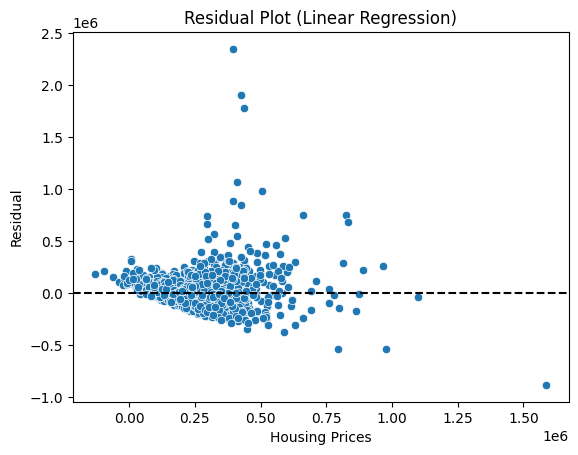

In [ ]:
#Residual Plots

yhat = model.predict()
residuals = Y - yhat
ax = sns.scatterplot(x=yhat, y=residuals)
ax.axhline(y=0, color='black', linestyle='dashed')
plt.title('Residual Plot (Linear Regression)')
plt.xlabel("Housing Prices")
plt.ylabel("Residual")
np.std(residuals)

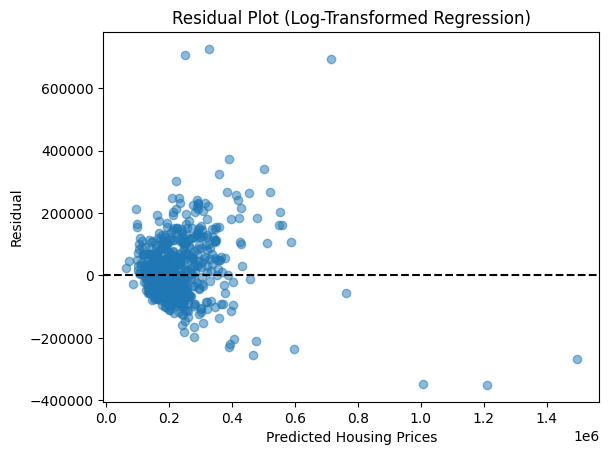

In [ ]:
#Applying log to all Y values to create log-transformed regression
Y_log = np.log(Y)

#Splitting data into training and test data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_log, test_size=0.2, random_state=42)

#Creating model
model = LinearRegression()
model.fit(X_train, Y_train)

#Calculating the residuals
Y_pred_log = model.predict(X_test)
Y_pred = np.exp(Y_pred_log)
Y_actual = np.exp(Y_test)
residuals = Y_actual - Y_pred

#Plot the residuals
plt.scatter(Y_pred, residuals, alpha=0.5)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Predicted Housing Prices')
plt.ylabel('Residual')
plt.title('Residual Plot (Log-Transformed Regression)')
plt.show()

In [ ]:
#Random forest data sets
all_factors = final_merged[['Average Price','Life Expectancy','Age-Adjusted Death Rate','Child Mortality Rate',
                            'Infant Mortality Rate','% Frequent Physical Distress','% Frequent Mental Distress',
                            '% Adults with Diabetes','HIV Prevalence Rate','% Food Insecure','% Limited Access to Healthy Foods',
                            'Drug Overdose Mortality Rate','% Insufficient Sleep','% Uninsured Adults','% Uninsured Children',
                            'Other Primary Care Provider Rate','High School Graduation Rate','% Disconnected Youth','Average Grade Performance',
                            'Segregation Index','Spending per Pupil','School Funding Adequacy',"Women's Median Earnings","Men's Median Earnings",
                            'Gender Pay Gap','Median Household Income','% Enrolled in Free or Reduced Lunch','% Household Income Required for Child Care Expenses',
                            'Child Care Centers per 1,000 Children','Homicide Rate','Suicide Rate (Age-Adjusted)','Firearm Fatalities Rate',
                            'Motor Vehicle Mortality Rate','Juvenile Arrest Rate','% Voter Turnout','% Census Participation','Traffic Volume',
                            '% Homeowners','% Households with Severe Cost Burden','% Households with Broadband Access','Population',
                            '% Less than 18 Years of Age','% 65 and Over','% Black','% American Indian or Alaska Native','% Asian',
                            '% Native Hawaiian or Other Pacific Islander','% Hispanic','% Non-Hispanic White','% Not Proficient in English',
                            '% Female','% Rural','Years of Potential Life Lost Rate','% Fair or Poor Health','Average Number of Physically Unhealthy Days',
                            'Average Number of Mentally Unhealthy Days','% Adults Reporting Currently Smoking','% Adults with Obesity','Food Environment Index',
                            '% Physically Inactive','% With Access to Exercise Opportunities','% Excessive Drinking','% Driving Deaths with Alcohol Involvement',
                            'Chlamydia Rate','Teen Birth Rate','% Uninsured','Primary Care Physicians Rate','Dentist Rate','Mental Health Provider Rate',
                            'Preventable Hospitalization Rate','% with Annual Mammogram','% Vaccinated','% Completed High School','% Some College',
                            '% Unemployed','% Children in Poverty','Income Ratio','% Children in Single-Parent Households','Social Association Rate',
                            'Injury Death Rate','% Severe Housing Problems','% Drive Alone to Work','% Long Commute - Drives Alone'
                            ]]
social_factors = all_factors.drop(['Age-Adjusted Death Rate','Child Mortality Rate',
                            'Infant Mortality Rate','% Frequent Physical Distress','% Frequent Mental Distress',
                            '% Adults with Diabetes','HIV Prevalence Rate','% Food Insecure','% Limited Access to Healthy Foods',
                            'Drug Overdose Mortality Rate','% Insufficient Sleep','Spending per Pupil','School Funding Adequacy',"Women's Median Earnings","Men's Median Earnings",
                            'Gender Pay Gap','Median Household Income','% Enrolled in Free or Reduced Lunch','% Household Income Required for Child Care Expenses',
                            '% Households with Severe Cost Burden','% Fair or Poor Health','Average Number of Physically Unhealthy Days',
                            'Average Number of Mentally Unhealthy Days','% Adults Reporting Currently Smoking','% Adults with Obesity','Food Environment Index',
                            '% Physically Inactive','% With Access to Exercise Opportunities','% Excessive Drinking','% Driving Deaths with Alcohol Involvement',
                            'Chlamydia Rate','Preventable Hospitalization Rate','% with Annual Mammogram','% Vaccinated','Injury Death Rate', 'Life Expectancy'], axis=1)
economic_factors = all_factors.drop(['Life Expectancy','Age-Adjusted Death Rate','Child Mortality Rate',
                            'Infant Mortality Rate','% Frequent Physical Distress','% Frequent Mental Distress',
                            '% Adults with Diabetes','Gender Pay Gap','HIV Prevalence Rate','% Food Insecure','% Limited Access to Healthy Foods',
                            'Drug Overdose Mortality Rate','% Insufficient Sleep','High School Graduation Rate','% Disconnected Youth','Average Grade Performance',
                            'Segregation Index','Child Care Centers per 1,000 Children','Homicide Rate','Suicide Rate (Age-Adjusted)','Firearm Fatalities Rate',
                            'Motor Vehicle Mortality Rate','Juvenile Arrest Rate','% Voter Turnout','% Census Participation','Traffic Volume','% Less than 18 Years of Age','% 65 and Over','% Black','% American Indian or Alaska Native','% Asian',
                            '% Native Hawaiian or Other Pacific Islander','% Hispanic','% Non-Hispanic White','% Not Proficient in English',
                            '% Female','% Rural','Years of Potential Life Lost Rate','% Fair or Poor Health','Average Number of Physically Unhealthy Days',
                            'Average Number of Mentally Unhealthy Days','% Adults Reporting Currently Smoking','% Adults with Obesity','Food Environment Index',
                            '% Physically Inactive','% With Access to Exercise Opportunities','% Excessive Drinking','% Driving Deaths with Alcohol Involvement',
                            'Chlamydia Rate','Teen Birth Rate','Dentist Rate','Mental Health Provider Rate',
                            'Preventable Hospitalization Rate','% with Annual Mammogram','% Vaccinated','% Completed High School','% Some College','% Children in Single-Parent Households','Social Association Rate',
                            'Injury Death Rate','% Severe Housing Problems','% Drive Alone to Work','% Long Commute - Drives Alone', 'Population'], axis=1)
health_factor = all_factors.drop(['High School Graduation Rate','% Disconnected Youth','Average Grade Performance',
                            'Segregation Index','Spending per Pupil','School Funding Adequacy',"Women's Median Earnings","Men's Median Earnings",
                            'Gender Pay Gap','Median Household Income','% Enrolled in Free or Reduced Lunch','% Household Income Required for Child Care Expenses',
                            'Child Care Centers per 1,000 Children','Homicide Rate','Suicide Rate (Age-Adjusted)','Firearm Fatalities Rate',
                            'Motor Vehicle Mortality Rate','Juvenile Arrest Rate','% Voter Turnout','% Census Participation','Traffic Volume',
                            '% Homeowners','% Households with Severe Cost Burden','% Households with Broadband Access','% Black','% American Indian or Alaska Native','% Asian',
                            '% Native Hawaiian or Other Pacific Islander','% Hispanic','% Non-Hispanic White','% Not Proficient in English',
                            '% Female','% Rural','% Completed High School','% Some College',
                            '% Unemployed','% Children in Poverty','Income Ratio','% Children in Single-Parent Households','Social Association Rate',
                            'Injury Death Rate','% Severe Housing Problems','% Drive Alone to Work','% Long Commute - Drives Alone'], axis=1)


All Factors Model
Train R²: 0.970463918203872
Test R²: 0.8603560547727109
RMSE: 63099.388446684585
MAE: 42018.05811499178


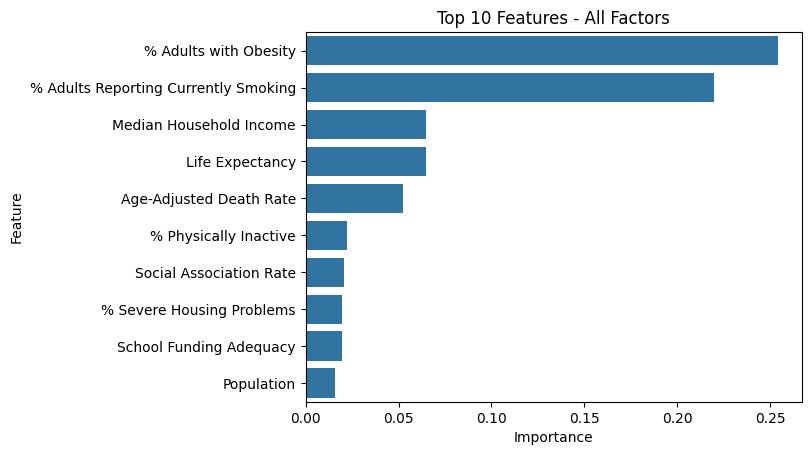

Social Factors Model
Train R²: 0.9586877554406471
Test R²: 0.7433033747188722
RMSE: 85550.8196268458
MAE: 49445.13051169688


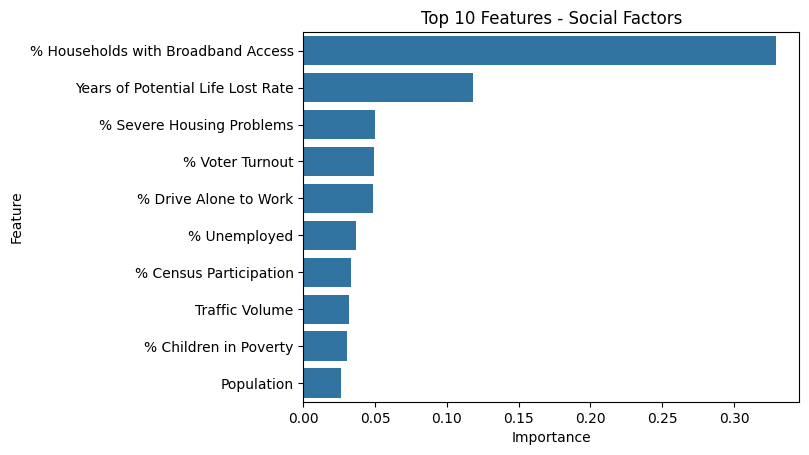

Economic Factors Model
Train R²: 0.9564039695360046
Test R²: 0.78680862955648
RMSE: 77964.86043300417
MAE: 51794.97217473915


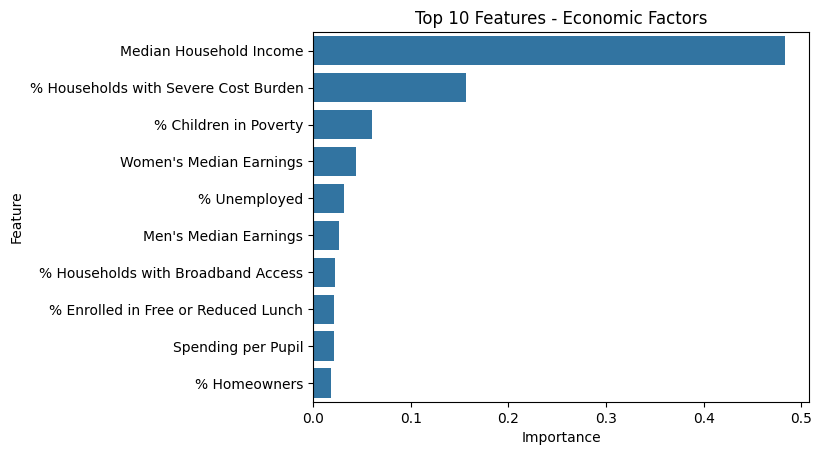

Health Factors Model
Train R²: 0.9640812870939687
Test R²: 0.7960162907306053
RMSE: 76262.64039448292
MAE: 47587.66315354202


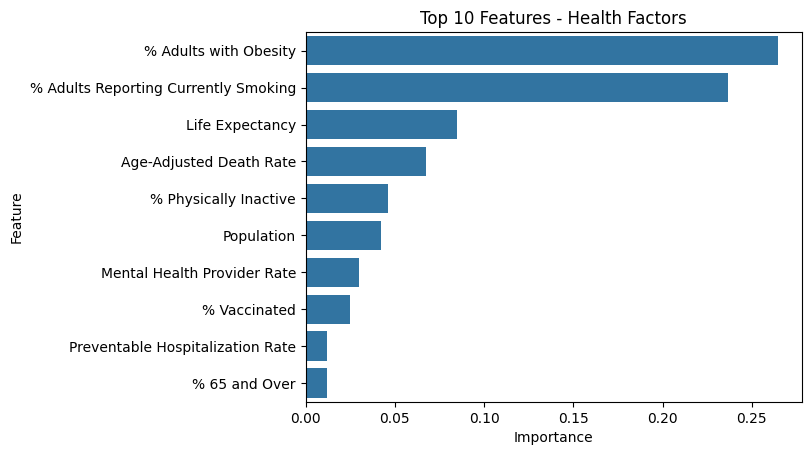

In [ ]:
#All Factors Random Forest
X_all = all_factors.drop(columns=['Average Price'])
y_all = all_factors['Average Price']

X_all = SimpleImputer(strategy="mean").fit_transform(X_all)
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, test_size=0.2, random_state=300000)

model_all = RandomForestRegressor(n_estimators=150, random_state=300000)
model_all.fit(X_train_all, y_train_all)
y_pred_all = model_all.predict(X_test_all)

print("All Factors Model")
print("Train R²:", model_all.score(X_train_all, y_train_all))
print("Test R²:", r2_score(y_test_all, y_pred_all))
print("RMSE:", np.sqrt(mean_squared_error(y_test_all, y_pred_all)))
print("MAE:", mean_absolute_error(y_test_all, y_pred_all))


#All Factors Feature Importance Plot
feat_all = pd.DataFrame({
    "Feature": all_factors.drop(columns=["Average Price"]).columns,
    "Importance": model_all.feature_importances_
}).sort_values(by="Importance", ascending=False)

sns.barplot(x=feat_all["Importance"][:10], y=feat_all["Feature"][:10])
plt.title("Top 10 Features - All Factors")
plt.show()



#Social Factors Random Forest
X_social = social_factors.drop(columns=['Average Price'])
y_social = social_factors['Average Price']

X_social = SimpleImputer(strategy="mean").fit_transform(X_social)
X_train_social, X_test_social, y_train_social, y_test_social = train_test_split(X_social, y_social, test_size=0.2, random_state=300000)

model_social = RandomForestRegressor(n_estimators=150, random_state=300000)
model_social.fit(X_train_social, y_train_social)
y_pred_social = model_social.predict(X_test_social)

print("Social Factors Model")
print("Train R²:", model_social.score(X_train_social, y_train_social))
print("Test R²:", r2_score(y_test_social, y_pred_social))
print("RMSE:", np.sqrt(mean_squared_error(y_test_social, y_pred_social)))
print("MAE:", mean_absolute_error(y_test_social, y_pred_social))

#Social Factors Feature Importance Plot
feat_social = pd.DataFrame({
    "Feature": social_factors.drop(columns=["Average Price"]).columns,
    "Importance": model_social.feature_importances_
}).sort_values(by="Importance", ascending=False)

sns.barplot(x=feat_social["Importance"][:10], y=feat_social["Feature"][:10])
plt.title("Top 10 Features - Social Factors")
plt.show()

#Economic Factors
X_econ = economic_factors.drop(columns=['Average Price'])
y_econ = economic_factors['Average Price']

X_econ = SimpleImputer(strategy="mean").fit_transform(X_econ)
X_train_econ, X_test_econ, y_train_econ, y_test_econ = train_test_split(X_econ, y_econ, test_size=0.2, random_state=300000)

model_econ = RandomForestRegressor(n_estimators=150, random_state=300000)
model_econ.fit(X_train_econ, y_train_econ)
y_pred_econ = model_econ.predict(X_test_econ)

print("Economic Factors Model")
print("Train R²:", model_econ.score(X_train_econ, y_train_econ))
print("Test R²:", r2_score(y_test_econ, y_pred_econ))
print("RMSE:", np.sqrt(mean_squared_error(y_test_econ, y_pred_econ)))
print("MAE:", mean_absolute_error(y_test_econ, y_pred_econ))


#Economic Factors Feature Importance Plot
feat_econ = pd.DataFrame({
    "Feature": economic_factors.drop(columns=["Average Price"]).columns,
    "Importance": model_econ.feature_importances_
}).sort_values(by="Importance", ascending=False)

sns.barplot(x=feat_econ["Importance"][:10], y=feat_econ["Feature"][:10])
plt.title("Top 10 Features - Economic Factors")
plt.show()

#Health Factors Model
X_health = health_factor.drop(columns=['Average Price'])
y_health = health_factor['Average Price']

X_health = SimpleImputer(strategy="mean").fit_transform(X_health)
X_train_health, X_test_health, y_train_health, y_test_health = train_test_split(X_health, y_health, test_size=0.2, random_state=300000)

model_health = RandomForestRegressor(n_estimators=150, random_state=300000)
model_health.fit(X_train_health, y_train_health)
y_pred_health = model_health.predict(X_test_health)

print("Health Factors Model")
print("Train R²:", model_health.score(X_train_health, y_train_health))
print("Test R²:", r2_score(y_test_health, y_pred_health))
print("RMSE:", np.sqrt(mean_squared_error(y_test_health, y_pred_health)))
print("MAE:", mean_absolute_error(y_test_health, y_pred_health))

#Health Factors Feature Importance Plot
feat_health = pd.DataFrame({
    "Feature": health_factor.drop(columns=["Average Price"]).columns,
    "Importance": model_health.feature_importances_
}).sort_values(by="Importance", ascending=False)

sns.barplot(x=feat_health["Importance"][:10], y=feat_health["Feature"][:10])
plt.title("Top 10 Features - Health Factors")
plt.show()

In [ ]:
print(feat_all.head(10))
print(feat_social.head(10))
print(feat_econ.head(10))
print(feat_health.head(10))

                                 Feature  Importance
56                 % Adults with Obesity    0.254204
55  % Adults Reporting Currently Smoking    0.219632
24               Median Household Income    0.064971
0                        Life Expectancy    0.064886
1                Age-Adjusted Death Rate    0.052335
58                 % Physically Inactive    0.022174
77               Social Association Rate    0.020576
79             % Severe Housing Problems    0.019706
20               School Funding Adequacy    0.019322
39                            Population    0.015779
                               Feature  Importance
17  % Households with Broadband Access    0.328967
30   Years of Potential Life Lost Rate    0.118074
43           % Severe Housing Problems    0.049734
13                     % Voter Turnout    0.049376
44               % Drive Alone to Work    0.048406
38                        % Unemployed    0.036896
14              % Census Participation    0.033299
15       

In [ ]:
#Creating copy of all_factors so original df is not messed with
df = all_factors.copy()


X = df.drop(columns=['Average Price'])
y = df['Average Price']

#Creating random forest model
imputer = SimpleImputer(strategy="mean")
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=300000)
model = RandomForestRegressor(n_estimators=150, random_state=300000)
model.fit(X_train, y_train)


interactive_features = [
    '% Adults with Obesity',
    'Median Household Income',
    'Age-Adjusted Death Rate',
    '% Adults Reporting Currently Smoking',
    'Life Expectancy',
    'Population',
    '% Children in Poverty',
    '% Unemployed',
    '% 65 and Over',
    '% Voter Turnout'
]

# Mean values for reference
feature_means = X_imputed.mean()

#Function that predicts price based on other variables
def predict_price(**kwargs):
    input_data = feature_means.copy()
    for feature, value in kwargs.items():
        input_data[feature] = value
    prediction = model.predict([input_data])[0]
    print(f"Predicted Average Price: ${prediction:,.2f}")

#Creating the sliders
interact_ui = {
    feature: FloatSlider(
        value=feature_means[feature],
        min=X_imputed[feature].min(),
        max=X_imputed[feature].max(),
        step=(X_imputed[feature].max() - X_imputed[feature].min()) / 100,
        description=feature[:25],  # slightly longer truncate
        continuous_update=False,
        layout={'width': '600px'}
    )
    for feature in interactive_features
}

#Allows user to interact with sliders
interact(predict_price, **interact_ui)

interactive(children=(FloatSlider(value=37.36993076162216, continuous_update=False, description='% Adults with…

<function __main__.predict_price(**kwargs)>

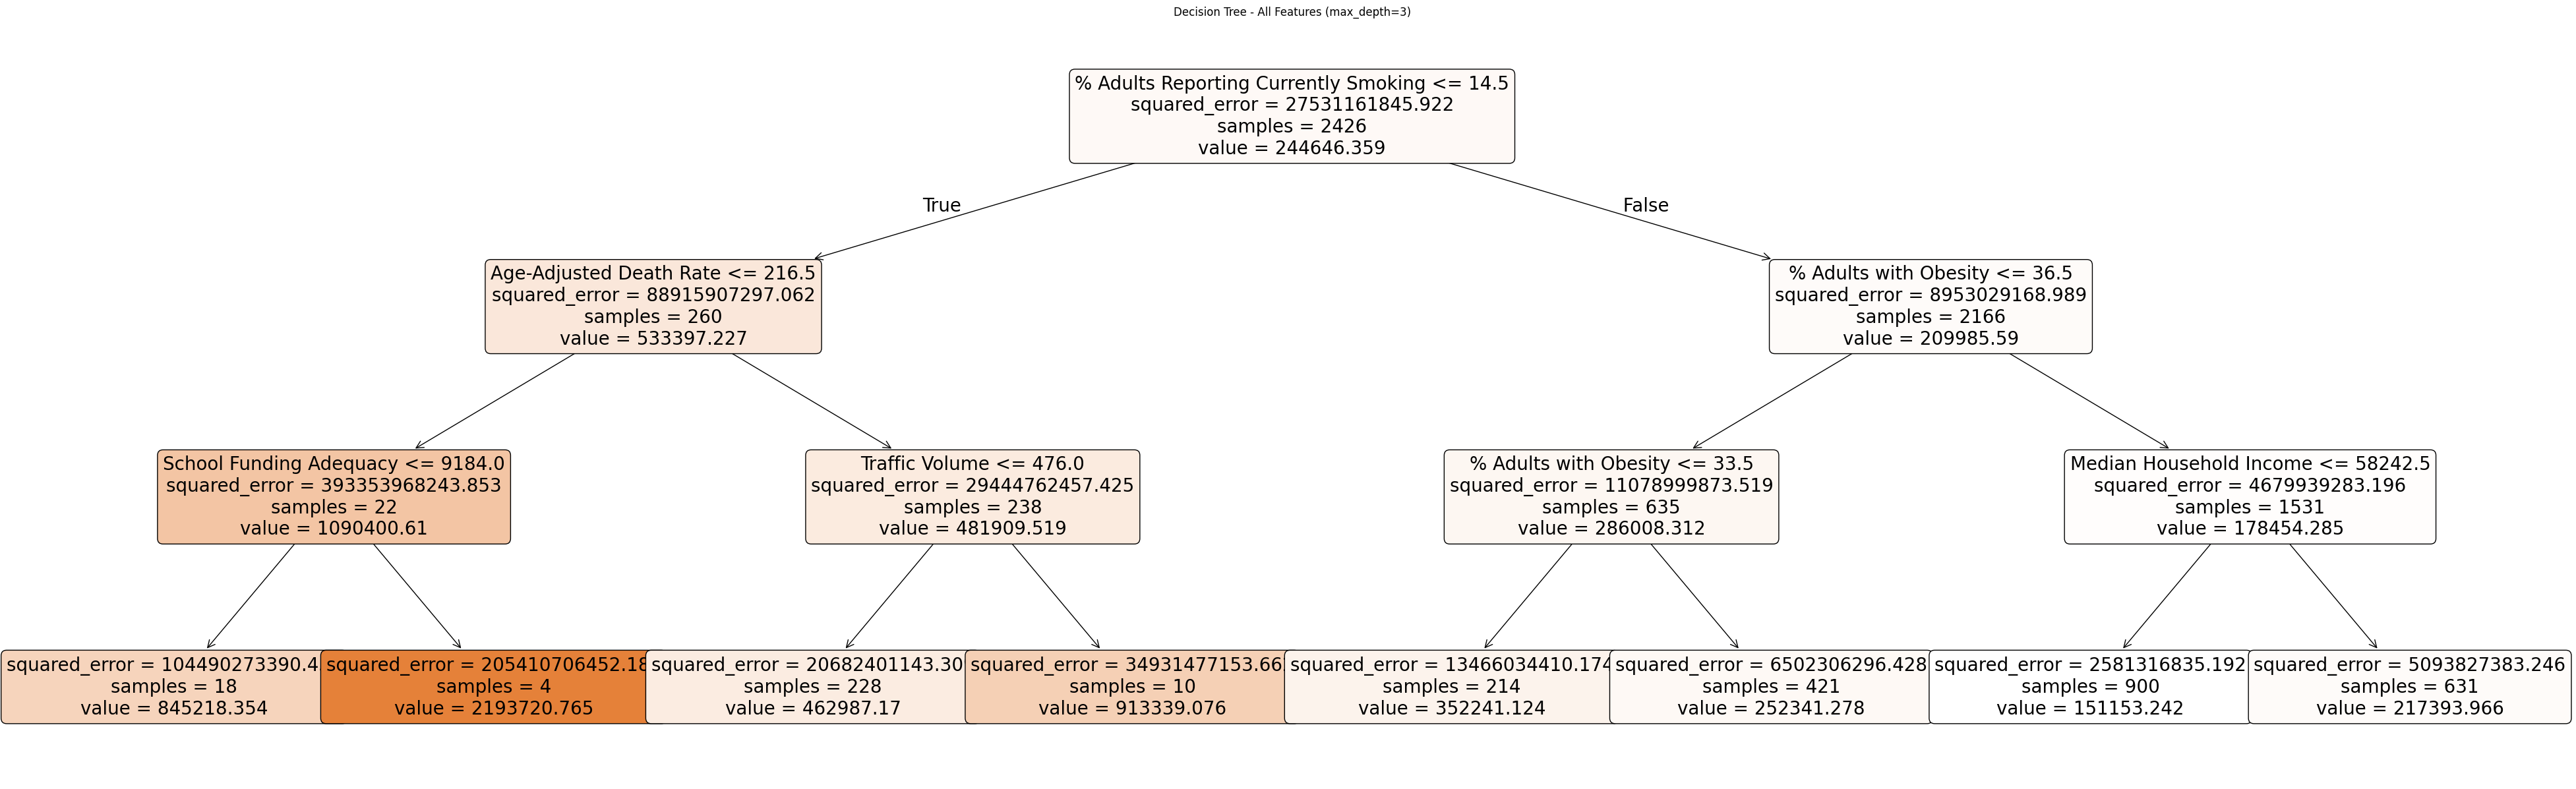

In [ ]:
X_df = pd.DataFrame(X_all, columns=all_factors.drop(columns=['Average Price']).columns)
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(X_df, y_all, test_size=0.2, random_state=300000)

#Fitting the Decision Tree
tree_model = DecisionTreeRegressor(random_state=300000, max_depth=3)
tree_model.fit(X_train_tree, y_train_tree)

#Plotting the Decision Tree
fig = plt.figure(figsize=(50, 15))
plot_tree(tree_model,
          feature_names=X_df.columns,
          filled=True,
          impurity=True,
          rounded=True,
          fontsize=20,)

#Saving the model as a .png
plt.savefig("decision_tree_full.png", dpi=300, bbox_inches="tight")
plt.title("Decision Tree - All Features (max_depth=3)")
plt.show()

In [ ]:
final_merged.head()

,SizeRank,County,State,Average Price,CombinedFIPS,Life Expectancy,# Deaths_x,Age-Adjusted Death Rate,# Child Deaths,Child Mortality Rate,...,Social Association Rate,# Injury Deaths,Injury Death Rate,Presence of Water Violation,% Severe Housing Problems,Severe Housing Cost Burden,Overcrowding,Inadequate Facilities,% Drive Alone to Work,% Long Commute - Drives Alone
0,0,los angeles,california,860687.82,6037,80.1,105949.0,321.0,3298.0,35.0,...,5.9,24324.0,49.0,Yes,32.0,23.0,11.0,2.0,68.0,49.0
1,1,cook,illinois,299644.18,17031,77.9,68485.0,394.0,2804.0,57.0,...,7.1,20065.0,78.0,Yes,20.0,17.0,3.0,1.0,57.0,52.0
2,2,harris,texas,281965.71,48201,77.9,54906.0,386.0,2921.0,53.0,...,5.5,15203.0,65.0,Yes,20.0,15.0,6.0,1.0,74.0,47.0
3,3,maricopa,arizona,466483.42,4013,78.2,56102.0,375.0,2444.0,52.0,...,5.3,19493.0,87.0,Yes,17.0,13.0,4.0,1.0,69.0,38.0
4,4,san diego,california,923102.02,6073,80.8,31043.0,280.0,1067.0,33.0,...,6.4,9901.0,60.0,Yes,25.0,20.0,7.0,1.0,69.0,38.0


In [ ]:
#Adds leading zeros and converts to string
final_merged['CombinedFIPS'] = final_merged['CombinedFIPS'].astype(str).str.zfill(5)

#Mapping based on FIPS code
fig = px.choropleth(
    final_merged,
    geojson="https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json",
    locations='CombinedFIPS',
    color='Average Price',
    color_continuous_scale="Turbo",
    scope="usa",
    hover_name='County',
    hover_data={
        'State': True,
        'Average Price': ':.2f',
        'CombinedFIPS': False
    },
    labels={'Average Price': 'Avg Home Price'},
    title="Average Housing Price by County"
)

fig.update_layout(margin={"r":30,"t":40,"l":0,"b":0})
fig.show()
#No Louisiana or Alaskan counties included

In [ ]:
#important links
#https://www.redfin.com/news/housing-market-value-december-2024/?utm_source=chatgpt.com


In [ ]:
import joblib
joblib.dump(model, 'housing_model.pkl')
from google.colab import files
files.download('housing_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from statsmodels.api import OLS, add_constant
from stargazer.stargazer import Stargazer

# Prepare regression datasets
X_lin = final_merged[['Median Household Income', '% Unemployed', 'Spending per Pupil',
                      '% Households with Broadband Access', 'Severe Housing Cost Burden',
                      'Income Ratio', '% Household Income Required for Child Care Expenses']]
Y_lin = final_merged["Average Price"]

# Add constant to X
X_lin_const = add_constant(X_lin)

# Fit linear regression model
lin_model = OLS(Y_lin, X_lin_const).fit()

# Generate Stargazer table
stargazer = Stargazer([lin_model])
stargazer.title("Linear Regression Results: Economic Factors and Housing Price")
html_table = stargazer.render_html()

html_table[:2000]  # Displaying first part of the HTML output to confirm generation


'Linear Regression Results: Economic Factors and Housing Price<br><table style="text-align:center"><tr><td colspan="2" style="border-bottom: 1px solid black"></td></tr>\n<tr><td style="text-align:left"></td><td colspan="1"><em>Dependent variable: Average Price</em></td></tr><tr><td style="text-align:left"></td><tr><td style="text-align:left"></td><td>(1)</td></tr>\n<tr><td colspan="2" style="border-bottom: 1px solid black"></td></tr>\n\n<tr><td style="text-align:left">% Household Income Required for Child Care Expenses</td><td>2265.032<sup>***</sup></td></tr>\n<tr><td style="text-align:left"></td><td>(379.785)</td></tr>\n<tr><td style="text-align:left">% Households with Broadband Access</td><td>-594.852<sup></sup></td></tr>\n<tr><td style="text-align:left"></td><td>(401.941)</td></tr>\n<tr><td style="text-align:left">% Unemployed</td><td>4925.952<sup>***</sup></td></tr>\n<tr><td style="text-align:left"></td><td>(1837.268)</td></tr>\n<tr><td style="text-align:left">Income Ratio</td><td>